# Übung 5 - Der EM-Algorithmus

## Aufgabe 1 - Expectation-Maximization in 2D

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### load data from csv
data = np.array(pd.read_csv('2d-em.csv', header = None))

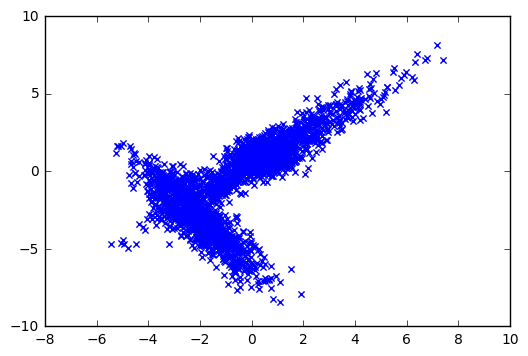

In [3]:
plt.scatter(data[:,0], data[:,1], marker = 'x');

In [4]:
def gaussian(x, mu, cov):
    x = np.array(x)
    mu = np.array(mu)
    cov = np.array(cov)
    eps = 0.0001
    dim = len(mu)
    while np.linalg.matrix_rank(cov) < dim:
        cov = cov + eps*np.eye(dim)
    exponent = -1./2*np.dot((x - mu).T, cov.dot(x - mu))
    return np.sqrt((2*np.pi)**dim * np.linalg.det(cov)) * np.exp(exponent)

def Mahalanobis_Abstand(x, cov, mu):
    temp = x-mu
    return [np.dot(t.T, np.linalg.inv(cov).dot(t)) for t in temp]

### Zur Bewertung der Güte des Clusterings
def Davies_Bouldin_Index(data, labels, mu, cov):
    #Clusters mit kleinem Davies-Bouldin Index sind gut
    k = len(mu)
    average_dist = [np.mean(Mahalanobis_Abstand(data[labels == label], 
                                                cov[label], mu[label])) for label in range(k)]
    temp = [ max([(average_dist[i] + average_dist[j])/(np.linalg.norm(mu[i] - mu[j])) 
                  for j in range(k) if j != i ]) for i in range(k) ]
    return 1./k*sum(temp)

In [5]:
def EM_Algorithm(data, k = 2, Zwischenschritte = False):
    #wenn Zwischenschritte = True, werden der 1., der 5. und der letzte Iterationsschritt abgespeichert und zurückgegeben
    n = len(data)
    probability_matrix = np.zeros((n, k))
    gamma_matrix = np.zeros((n, k))
    
    
    ### Initialisierung
    # Die Mittelpunkte der Cluster werden mit den Koordinaten zufällig gewählter Punkte initialisiert.
    mu = []
    mu.append(data[np.random.randint(len(data))])
    while len(mu)<k:
        new_point = data[np.random.randint(len(data))]
        if max([np.linalg.norm(new_point - m) for m in mu]) > 5./k:
            mu.append(new_point)
    # Die Varianz-Matrizen werden mit der Varianz der gesamten Daten initialisiert.
    cov_matrices = [np.cov(data.T)]*k 
    # Alle Cluster erhalten zu Beginn dasselbe Gewicht.
    pi = np.array([1./k]*k)
    
    ZwSchritt = []
    counter = 0
    while counter <= 100:
        counter += 1
        pi_alt = pi
        mu_alt = mu
        cov_matrices_alt = cov_matrices
        
        ### Expectation Step
        sum_vector = np.zeros(n)
        for i in range(n):
            for j in range(k):
                probability_matrix[i,j] = gaussian(data[i], mu[j], cov_matrices[j])
            sum_vector[i] = np.dot(pi, probability_matrix[i,:])

        for i in range(n):
            for j in range(k):
                gamma_matrix[i,j] = pi[j]*probability_matrix[i,j]/sum_vector[i]


        ### Maximization Step
        sum_gamma = sum(gamma_matrix)
        for j in range(k):
            mu[j] = np.array(sum([gamma_matrix[i,j]*data[i] for i in range(n)])/sum(gamma_matrix)[j])
            cov_matrices[j] = sum([gamma_matrix[i,j]*np.dot((data[i]-mu_alt[j])[:, np.newaxis], 
                                                                (data[i]-mu_alt[j])[:, np.newaxis].T) 
                                       for i in range(n)])/sum(gamma_matrix)[j]
        pi = np.array([sum(gamma_matrix)[j]/k for j in range(k)])
        
        
        # wenn sich die Parameter nicht mehr viel ändern: abbrechen
        if max(max([np.linalg.norm(mu[s]-mu_alt[s]) for s in range(len(mu))]), 
               max([np.linalg.norm(pi[s]-pi_alt[s]) for s in range(len(pi))])) < 0.5:
            break
        
        #Zu welchem Cluster gehören die Datenpunkte mit maximaler Wahrscheinlichkeit?
        labels = np.argmax(gamma_matrix, axis = 1)   
        
        if Zwischenschritte == True and counter in [1, 5]:
            ZwSchritt.append({'mu': mu, 'cov': cov_matrices, 'labels': labels, 'Iteration': counter})

    if Zwischenschritte == True:
            ZwSchritt.append({'mu': mu, 'cov': cov_matrices, 'labels': labels, 'Iteration': counter})
    
    return mu, cov_matrices, pi, labels, ZwSchritt

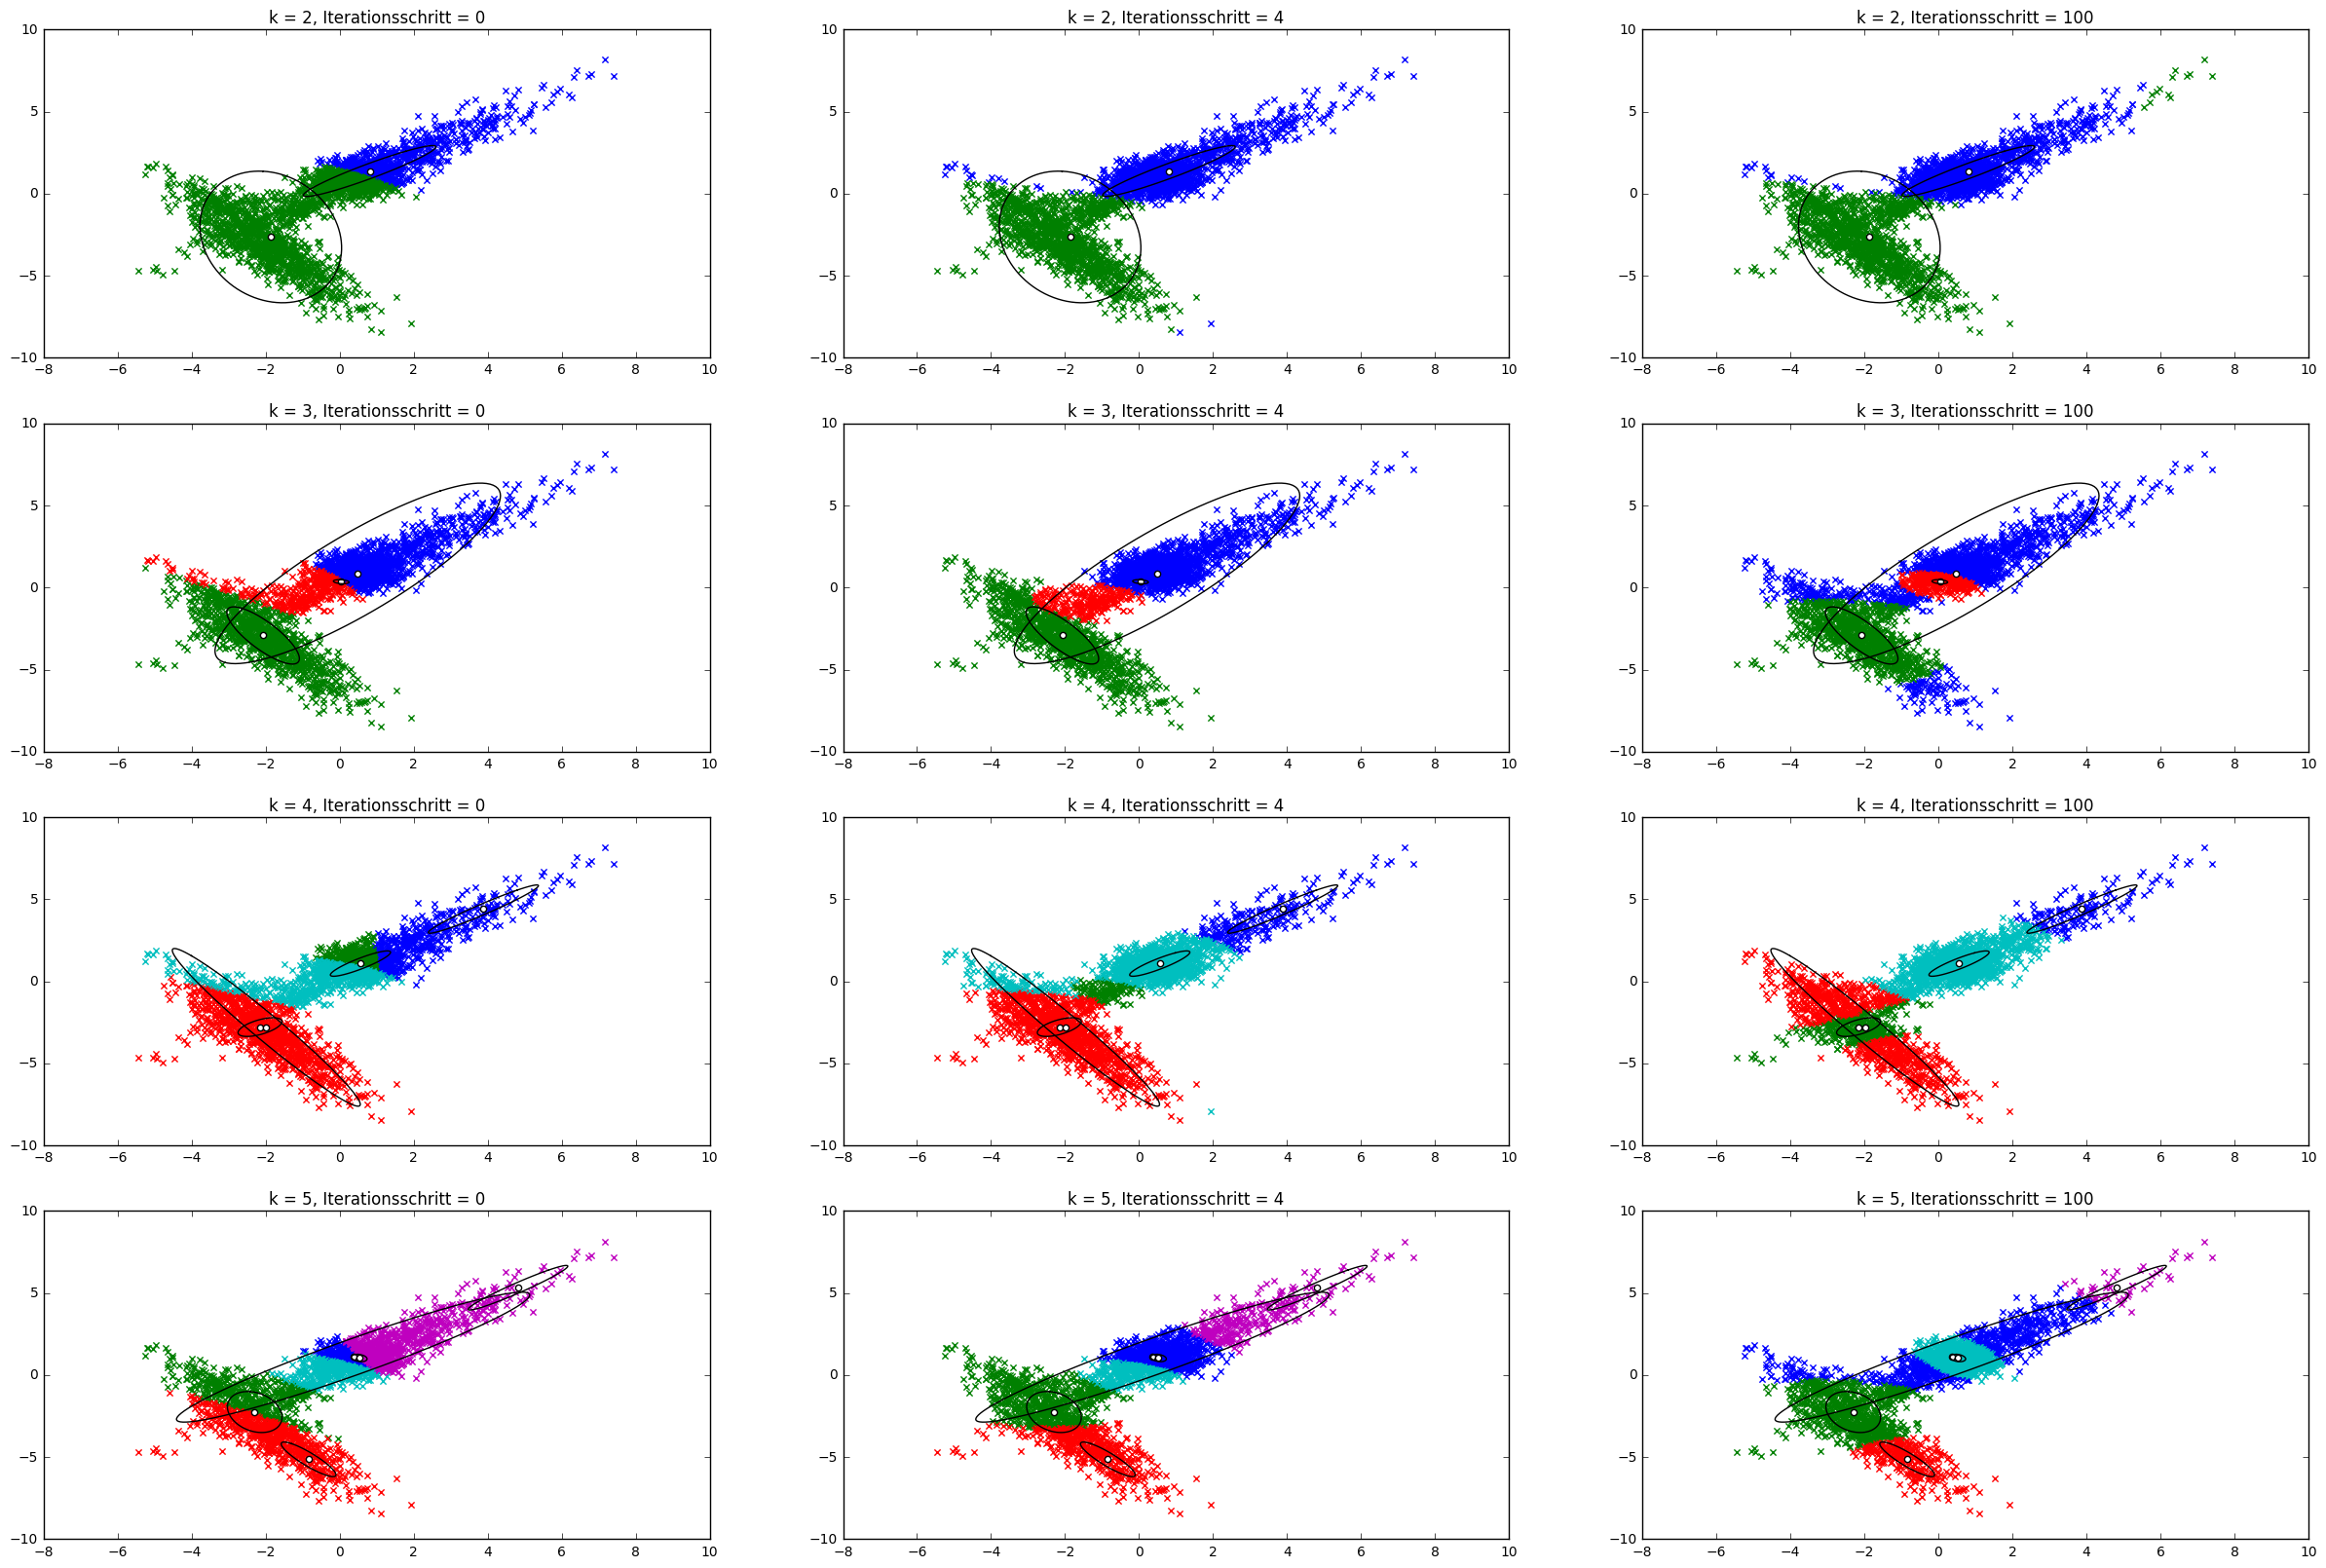

In [6]:
### Wir führen den EM-Algorithmus mit mehreren Werten für die Anzahl der Cluster durch.

DB_Index = []
mu = {}
cov = {}
labels = {}
Zwischenschritte = {}
for k in range(2,6):
    mu[k], cov[k], pi, labels[k], Zwischenschritte[k] = EM_Algorithm(data, k, Zwischenschritte=True)
    DB_Index.append(Davies_Bouldin_Index(data, labels[k], mu[k], cov[k]))
    
    
### Plotten der Ergebnisse

colorlist = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
fig, axes = plt.subplots(4, 3, figsize = (30, 20))

# Vorbereitungen für die Ellipsen
num_points = 100
radius = 1
arcs = np.linspace(0, 2 * np.pi, num_points)
x = radius * np.sin(arcs)
y = radius * np.cos(arcs)
xy = np.array(list(zip(x, y)))

#plotte alle Zwischenschritte
for k in range(2,6):
    legend_list = []
    for z in range(len(Zwischenschritte[k])):
        mu_now = Zwischenschritte[k][z]['mu']
        cov_now = Zwischenschritte[k][z]['cov']
        labels_now = Zwischenschritte[k][z]['labels']
        for i in range(k):
            legend_list.append('Cluster' + str(i))
            data_now = np.array([data[s] for s in range(len(data)) if labels_now[s] == i])
            axes[k-2, z].scatter(data_now[:,0], data_now[:,1], 
                                 marker = 'x', c = colorlist[i], label = legend_list[-1])
            xy = np.array(list(zip(x, y)))
            #print(cov_now,k)
            x_ellipse, y_ellipse = zip(*xy.dot(cov_now[i]))
            axes[k-2, z].plot(x_ellipse + mu_now[i][0], y_ellipse + mu_now[i][1], c = 'k')
        axes[k-2, z].scatter([mu_now[s][0] for s in range(len(mu_now))], 
                             [mu_now[s][1] for s in range(len(mu_now))], 
                             c = 'w')
        axes[k-2, z].set_title('k = ' + str(k) + ', Iterationsschritt = ' 
                               + str(Zwischenschritte[k][z]['Iteration']-1))

In [ ]:
plt.plot(range(2,k+1), DB_Index)
plt.xlabel('Anzahl der Cluster')
plt.ylabel('Davies-Bouldin')
plt.title('Bewertung des Clusterings');

Fazit: Der EM-Algorithmus liefert auf diesem Datensatz das beste Ergebnis mit 2 Clustern.